# Модель для прогнозирования прибыли от добычи нефти


Для анализа предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. По данным построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Возможная прибыль и риски будет проанализирована техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Содержание
   
1. Описание данных
2. Обучение и проверка модели
3. Расчет прибыли

## Описание данных

`id` — уникальный идентификатор скважины;  
`f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);  
`product` — объём запасов в скважине (тыс. баррелей).

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data0 = pd.read_csv('geo_data_0.csv')
data1 = pd.read_csv('geo_data_1.csv')
data2 = pd.read_csv('geo_data_2.csv')

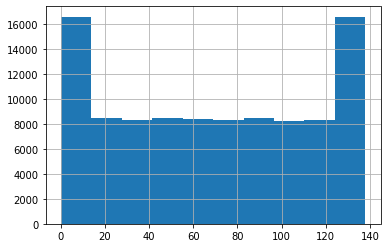

In [37]:
data1['product'].hist()

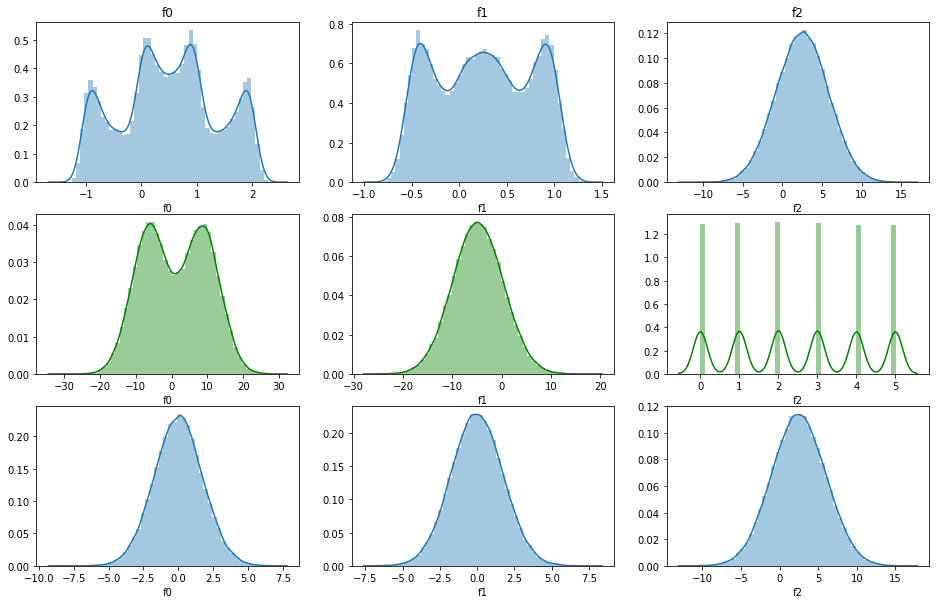

In [4]:
fig, axes = plt.subplots(3,3, figsize=(16,10))

sns.distplot(data0['f0'], ax = axes[0,0])
sns.distplot(data0['f1'], ax = axes[0,1])
sns.distplot(data0['f2'], ax = axes[0,2])
sns.distplot(data1['f0'], ax = axes[1,0], color = 'g')
sns.distplot(data1['f1'], ax = axes[1,1], color = 'g')
sns.distplot(data1['f2'], ax = axes[1,2], color = 'g')
sns.distplot(data2['f0'], ax = axes[2,0])
sns.distplot(data2['f1'], ax = axes[2,1])
sns.distplot(data2['f2'], ax = axes[2,2])


axes[0,0].set_title('f0')
axes[0,1].set_title('f1')
axes[0,2].set_title('f2')

plt.show()

In [5]:
data = pd.concat([data0, data1, data2])
print('Число дубликатов:', data.duplicated().sum())
print('Число пропусков:', data.isna().sum().sum())

Число дубликатов: 0
Число пропусков: 0


> - В распоряжении есть три набора данных, содержаших информацию о месторождениях в трех различных регионах. Для анализа нам понадобятся признаки f0, f1 и f2. Интересно, что в различных регионах каждый из них имеет собственное распределение: в первом регионе распределение признаков похоже на нормальное с несколькими пиками (для f0 и f2); во втором регионе
распределение нулевого признака имеет два пика, а второй признак принимает только целочисленные значения, которые принимаются с одинаковой частотой; в третьем регионе все признаки принимают дробные значения и имеют нормальное распределение.  
- С данными можно работать: в них нет ни порпусков, ни дубликатов.

## Обучение и проверка модели

In [6]:
def training_model(data):
    features = data.drop(["product","id"], axis=1)
    target = data["product"]
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=1)
    
    
    scaler = MinMaxScaler()
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.transform(features_valid)

    
    lr = LinearRegression(normalize=False).fit(features_train, target_train)
    preds = pd.Series(lr.predict(features_valid))
    mean = preds.mean()
    rmse = mean_squared_error(preds, target_valid) ** 0.5
    
    print('Средний запас сырья:', mean)
    print('RMSE:', rmse)
    
    return preds, mean, rmse, target_valid.reset_index(drop=True)

In [7]:
i = 1
for region in [data0, data1, data2]:
    print('Регион', i)
    training_model(region)
    i += 1
    if i <= 3:
        print('---')

Регион 1
Средний запас сырья: 92.49262459838843
RMSE: 37.74258669996437
---
Регион 2
Средний запас сырья: 69.12040524285577
RMSE: 0.8943375629130565
---
Регион 3
Средний запас сырья: 94.95683048585316
RMSE: 39.86671127773423


In [8]:
preds1, average_product1, rmse1, valid1 = training_model(data0)
preds2, average_product2, rmse2, valid2 = training_model(data1)
preds3, average_product3, rmse3, valid3 = training_model(data2)

Средний запас сырья: 92.49262459838843
RMSE: 37.74258669996437
Средний запас сырья: 69.12040524285577
RMSE: 0.8943375629130565
Средний запас сырья: 94.95683048585316
RMSE: 39.86671127773423


> Наилучший прогноз составляется для второго региона, который одновременно является анти-лидером в рейтинге объема запасов. Если при выборе региона наиболее важна точность прогноза - второй регион окажется наилучшим. Однако, если среда позволяет бизнесу ошибаться в прогнозах, то лучше выбрать первый или третий регионы - в них ошибка предсказания гораздо выше (38 тыс. баррелей против < 1), но объем запасов превосходит второй регион.

## Расчет прибыли

**Точка безубыточности**
$$ budget - income * n = 0  $$
$$ n = \frac{budget}{income} $$ 

In [9]:
BUDGET = 10 ** 10
INCOME = 450000

In [10]:
n = BUDGET / INCOME

In [57]:
print('При точке безубыточности в {:.2f} тыс. баррелей средний объем запасов в месторождениях должен составлять {:.2f} тыс. баррелей'.format(n + 1, n / 200))

При точке безубыточности в 22223.22 тыс. баррелей средний объем запасов в месторождениях должен составлять 111.11 тыс. баррелей


> Из расчетов видно, что запаса сырья в регионах не хватит для достижения точки безубыточности.

In [52]:
COUNT = 200
# функция для расчёта прибыли
def profit(predictions, target): 
    
    """
    - Принимает на вход целевые значения и предсказанные;
    - Выбирает месторождения с наибольшими предсказаниями (200) и находит их индексы в реальных данных;
    - Считает прибыль для данных месторождений.
    
    """
    preds_sorted = predictions.sort_values(ascending=False)
    selected_points = target[preds_sorted.index][:200]
    profit = selected_points.sum() * INCOME
    return profit - BUDGET

In [53]:
state = np.random.RandomState(42)
def conf_int_loss(predictions, target):
    values = []
    for i in range(1000):
        target_subsample = target.sample(500, replace=True, random_state=state)
        preds_subsample = predictions[target_subsample.index]
        values.append(profit(preds_subsample, target_subsample))
        
    lower = int(np.percentile(values, 2.5))
    upper = int(np.percentile(values, 97.5))
    mean = int(sum(values) / len(values))
    risk = st.percentileofscore(values, 0)
        
    return ((lower, upper), mean, risk)

In [54]:
conf_int_loss(preds1, valid1)

((-54499686, 999922208), 483620020, 3.2)

In [58]:
i = 1
for preds, target in zip([preds1, preds2, preds3], 
                         [valid1, valid2, valid3]):
    interval, mean_revenue, risk = conf_int_loss(preds, target)
    print(f"Регион {i}:")
    print(f"Средняя приыбль: {mean_revenue}")
    print(f"95% доверительный интервал: {interval}")
    print(f"Риск убытков: {risk}")
    print("-----------------------------------------\n\n")
    i+=1

Регион 1:
Средняя приыбль: 470403390
95% доверительный интервал: (-55824802, 993116436)
Риск убытков: 4.0
-----------------------------------------


Регион 2:
Средняя приыбль: 533691023
95% доверительный интервал: (77305967, 942961260)
Риск убытков: 1.3
-----------------------------------------


Регион 3:
Средняя приыбль: 419322716
95% доверительный интервал: (-148894157, 985954982)
Риск убытков: 7.9
-----------------------------------------




> В работе была составлена линейная модель для прогнозирования прибыли для трех различных регионов. С помощью техники бутстреп было проанализировано распределение возможной прибыли в 95% доверительном интервале, а также определены возможные риски убытков.  
Наиболее прибыльным регионом оказался второй, в нем ориентировочное значение прибыли достигается 533 691 023 руб. При этом наименьшая возможная прибыль с точностью 95% составит 77 305 967 руб, убытки возможны в 1,3% случаев.